# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lassonet import LassoNetClassifier



from RankCorr.picturedRocks import Rocks
import smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *

CPU times: user 10.9 s, sys: 485 ms, total: 11.4 s
Wall time: 13.4 s


In [3]:
logging.getLogger("numpy").setLevel(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)
    
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 10

gpus = 1
tpu_cores = None
precision=32

# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
possible_seeds = np.random.randint(low=1, high = 1000000, size = 400)
seed_index = 0

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [6]:
from os import path

In [7]:
dataset_dir = '../data/paul/'
model_save_path = '../data/paul/models/'
viz_save_path = '../data/paul/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [8]:
adata = sc.datasets.paul15()

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'paul15_clusters' as categorical
Trying to set attribute `._uns` of view, copying.


In [9]:
sm = smashpy.smashpy()
housekeeping_gene_direct = '../data/housekeeping_genes/'
sm.data_preparation(adata)
adata = sm.remove_general_genes(adata)
adata = sm.remove_housekeepingenes(adata, path=[housekeeping_gene_direct + "house_keeping_genes_Mouse_bone_marrow.txt"])
adata = sm.remove_housekeepingenes(adata, path=[housekeeping_gene_direct + "house_keeping_genes_Mouse_HSC.txt"])

 * Initialising ...



In [10]:
dict_annotation = {}

dict_annotation['1Ery']='Ery'
dict_annotation['2Ery']='Ery'
dict_annotation['3Ery']='Ery'
dict_annotation['4Ery']='Ery'
dict_annotation['5Ery']='Ery'
dict_annotation['6Ery']='Ery'
dict_annotation['7MEP']='MEP'
dict_annotation['8Mk']='Mk'
dict_annotation['9GMP']='GMP'
dict_annotation['10GMP']='GMP'
dict_annotation['11DC']='DC'
dict_annotation['12Baso']='Baso'
dict_annotation['13Baso']='Baso'
dict_annotation['14Mo']='Mo'
dict_annotation['15Mo']='Mo'
dict_annotation['16Neu']='Neu'
dict_annotation['17Neu']='Neu'
dict_annotation['18Eos']='Eos'
dict_annotation['19Lymph']='Lymph'

annotation = []
for celltype in adata.obs["paul15_clusters"].tolist():
    annotation.append(dict_annotation[celltype])

adata.obs['annotation'] = annotation
adata.obs['annotation'] = adata.obs['annotation'].astype("category")

In [11]:
adata.obs

paul15_clusters  n_counts annotation
0               7MEP     353.0        MEP
1               15Mo    2556.0         Mo
2               3Ery    4649.0        Ery
3               15Mo    4486.0         Mo
4               3Ery    5205.0        Ery
...              ...       ...        ...
2725            2Ery    4873.0        Ery
2726          13Baso    3553.0       Baso
2727            7MEP     443.0        MEP
2728            15Mo    3252.0         Mo
2729            3Ery    6401.0        Ery

[2730 rows x 3 columns]

In [12]:
X = adata.X.copy()

labels = adata.obs['annotation'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [13]:
input_size = X.shape[1]

In [14]:
X.shape

(2730, 3113)

# Set Up Models

### Baseline

In [15]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

CPU times: user 4min 1s, sys: 3.63 s, total: 4min 4s
Wall time: 2min 30s


## Train Smash Random Forest





In [15]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

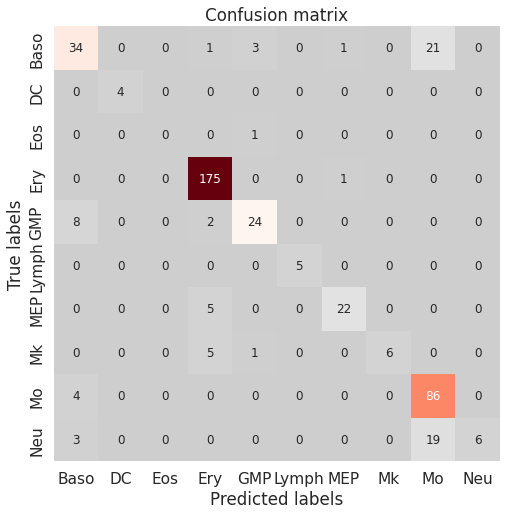

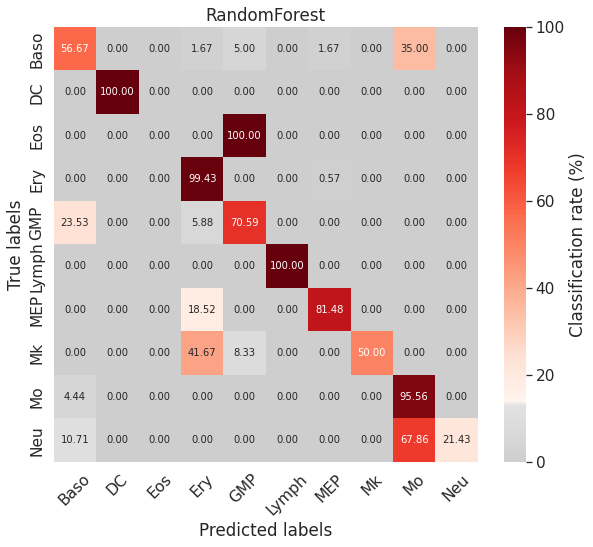

Accuracy: 0.8283752860411899: Misclassification: 0.17162471395881007
              precision    recall  f1-score   support

        Baso       0.69      0.57      0.62        60
          DC       1.00      1.00      1.00         4
         Eos       0.00      0.00      0.00         1
         Ery       0.93      0.99      0.96       176
         GMP       0.83      0.71      0.76        34
       Lymph       1.00      1.00      1.00         5
         MEP       0.92      0.81      0.86        27
          Mk       1.00      0.50      0.67        12
          Mo       0.68      0.96      0.80        90
         Neu       1.00      0.21      0.35        28

    accuracy                           0.83       437
   macro avg       0.81      0.68      0.70       437
weighted avg       0.84      0.83      0.81       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

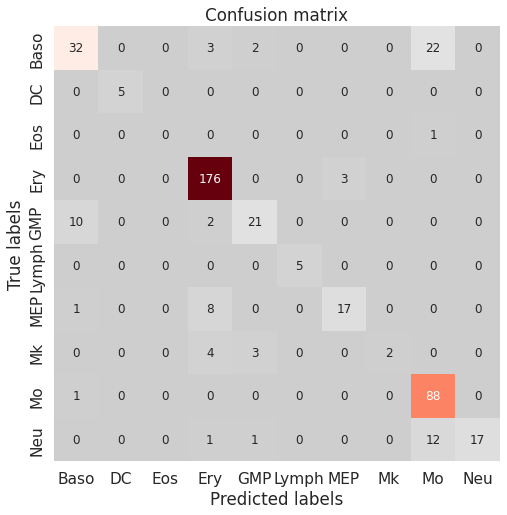

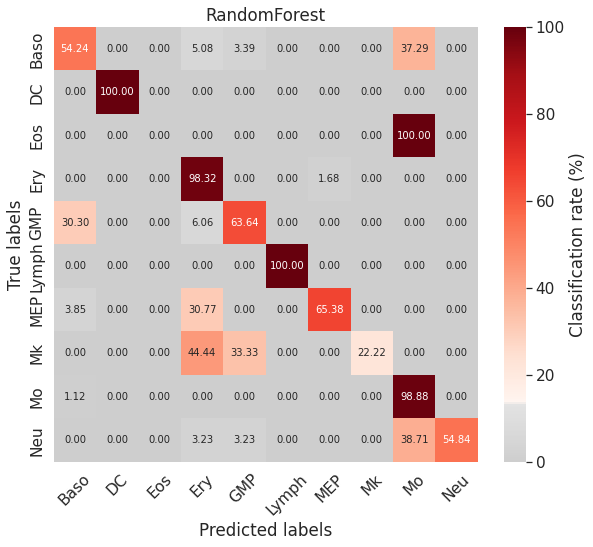

Accuracy: 0.8306636155606407: Misclassification: 0.16933638443935928
              precision    recall  f1-score   support

        Baso       0.73      0.54      0.62        59
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.91      0.98      0.94       179
         GMP       0.78      0.64      0.70        33
       Lymph       1.00      1.00      1.00         5
         MEP       0.85      0.65      0.74        26
          Mk       1.00      0.22      0.36         9
          Mo       0.72      0.99      0.83        89
         Neu       1.00      0.55      0.71        31

    accuracy                           0.83       437
   macro avg       0.80      0.66      0.69       437
weighted avg       0.84      0.83      0.82       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

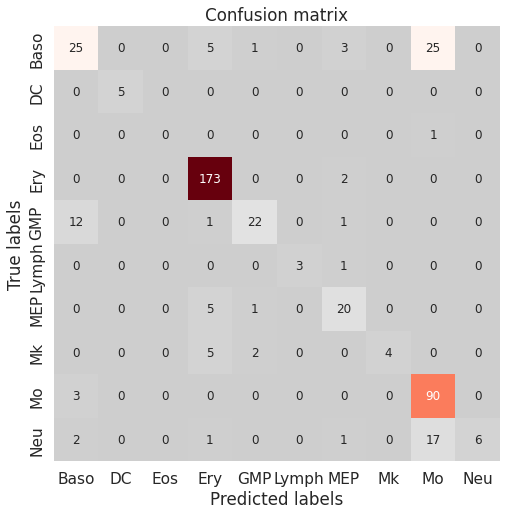

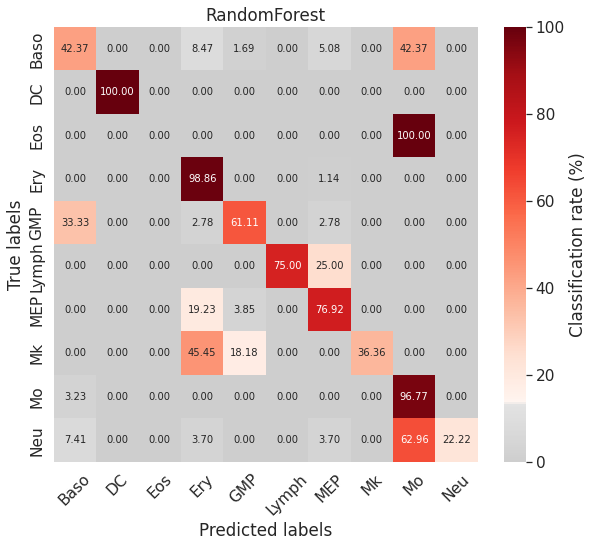

Accuracy: 0.7963386727688787: Misclassification: 0.2036613272311213
              precision    recall  f1-score   support

        Baso       0.60      0.42      0.50        59
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.91      0.99      0.95       175
         GMP       0.85      0.61      0.71        36
       Lymph       1.00      0.75      0.86         4
         MEP       0.71      0.77      0.74        26
          Mk       1.00      0.36      0.53        11
          Mo       0.68      0.97      0.80        93
         Neu       1.00      0.22      0.36        27

    accuracy                           0.80       437
   macro avg       0.77      0.61      0.64       437
weighted avg       0.81      0.80      0.77       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

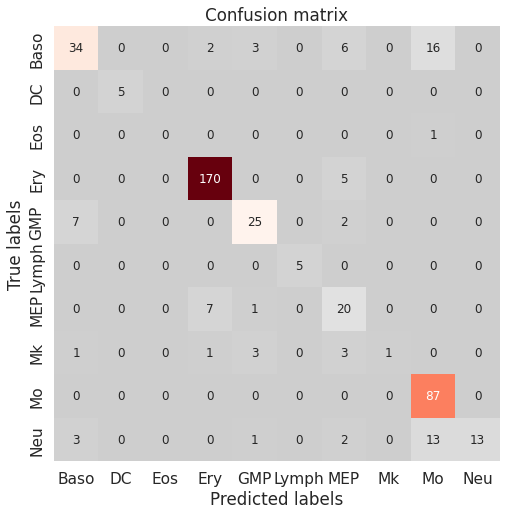

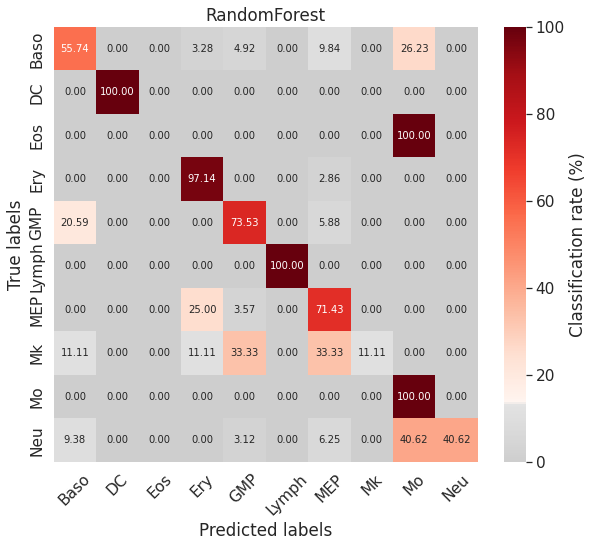

Accuracy: 0.8237986270022883: Misclassification: 0.17620137299771166
              precision    recall  f1-score   support

        Baso       0.76      0.56      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.94      0.97      0.96       175
         GMP       0.76      0.74      0.75        34
       Lymph       1.00      1.00      1.00         5
         MEP       0.53      0.71      0.61        28
          Mk       1.00      0.11      0.20         9
          Mo       0.74      1.00      0.85        87
         Neu       1.00      0.41      0.58        32

    accuracy                           0.82       437
   macro avg       0.77      0.65      0.66       437
weighted avg       0.84      0.82      0.81       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

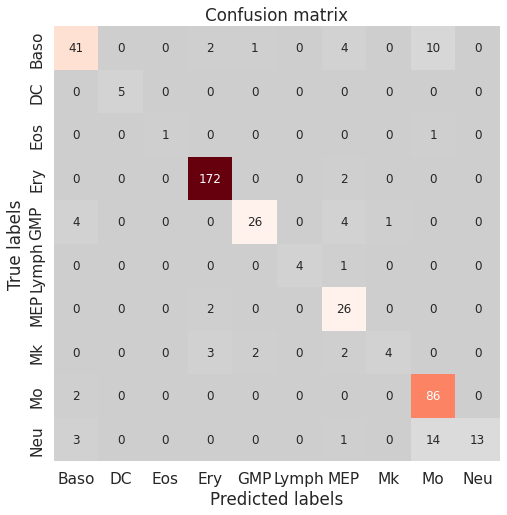

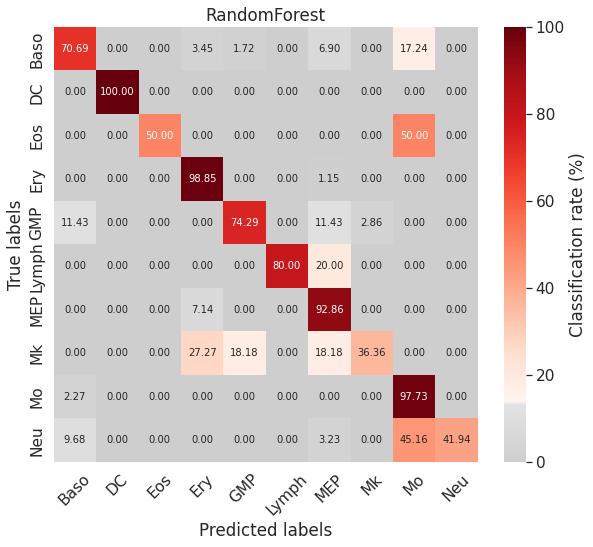

Accuracy: 0.8649885583524027: Misclassification: 0.13501144164759726
              precision    recall  f1-score   support

        Baso       0.82      0.71      0.76        58
          DC       1.00      1.00      1.00         5
         Eos       1.00      0.50      0.67         2
         Ery       0.96      0.99      0.97       174
         GMP       0.90      0.74      0.81        35
       Lymph       1.00      0.80      0.89         5
         MEP       0.65      0.93      0.76        28
          Mk       0.80      0.36      0.50        11
          Mo       0.77      0.98      0.86        88
         Neu       1.00      0.42      0.59        31

    accuracy                           0.86       437
   macro avg       0.89      0.74      0.78       437
weighted avg       0.88      0.86      0.86       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

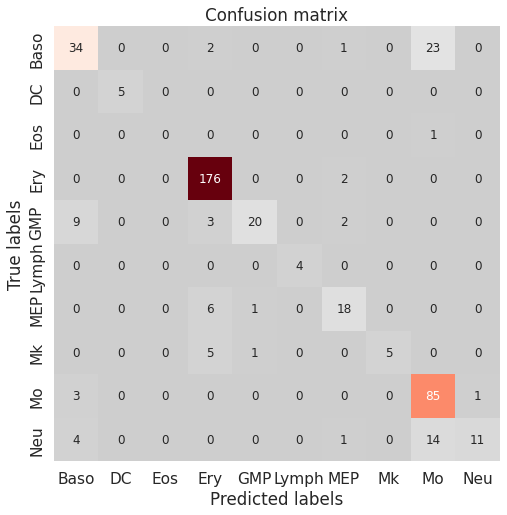

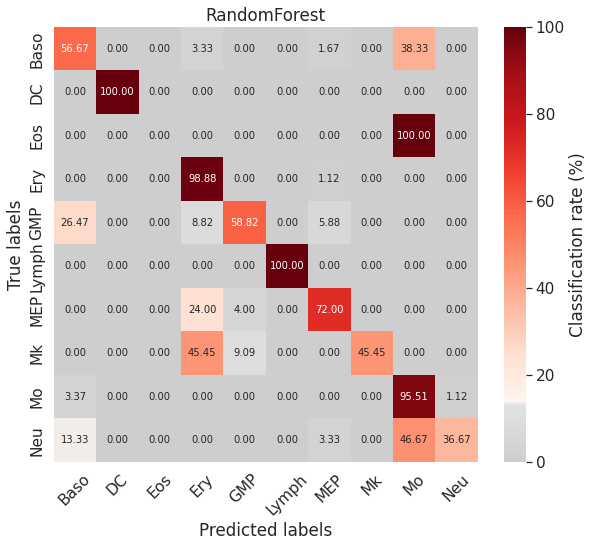

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.68      0.57      0.62        60
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.92      0.99      0.95       178
         GMP       0.91      0.59      0.71        34
       Lymph       1.00      1.00      1.00         4
         MEP       0.75      0.72      0.73        25
          Mk       1.00      0.45      0.62        11
          Mo       0.69      0.96      0.80        89
         Neu       0.92      0.37      0.52        30

    accuracy                           0.82       437
   macro avg       0.79      0.66      0.70       437
weighted avg       0.83      0.82      0.81       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

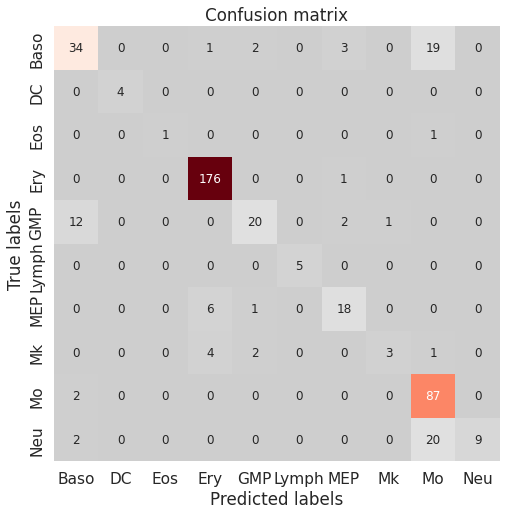

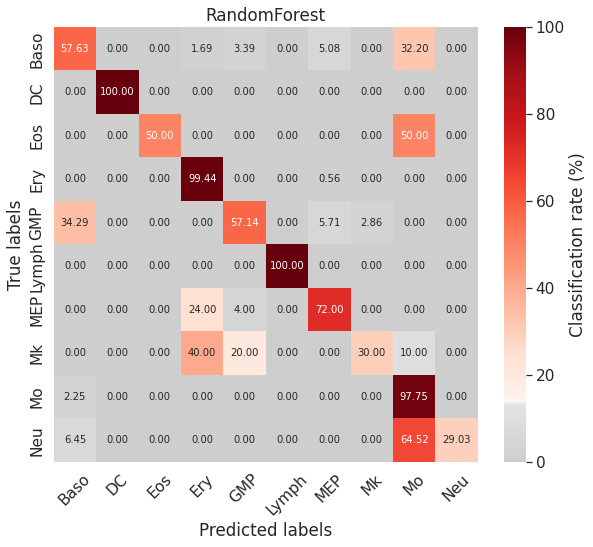

Accuracy: 0.816933638443936: Misclassification: 0.18306636155606404
              precision    recall  f1-score   support

        Baso       0.68      0.58      0.62        59
          DC       1.00      1.00      1.00         4
         Eos       1.00      0.50      0.67         2
         Ery       0.94      0.99      0.97       177
         GMP       0.80      0.57      0.67        35
       Lymph       1.00      1.00      1.00         5
         MEP       0.75      0.72      0.73        25
          Mk       0.75      0.30      0.43        10
          Mo       0.68      0.98      0.80        89
         Neu       1.00      0.29      0.45        31

    accuracy                           0.82       437
   macro avg       0.86      0.69      0.73       437
weighted avg       0.83      0.82      0.80       437

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

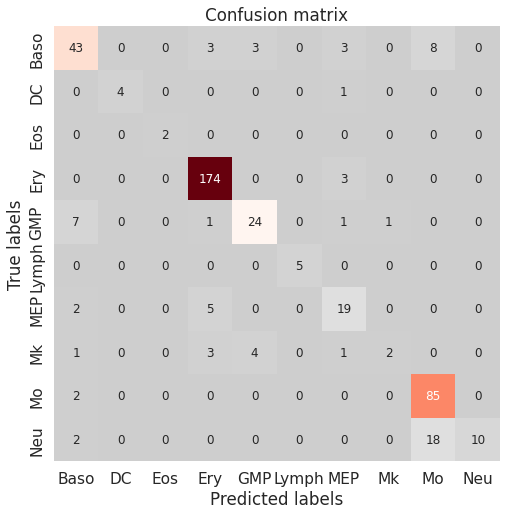

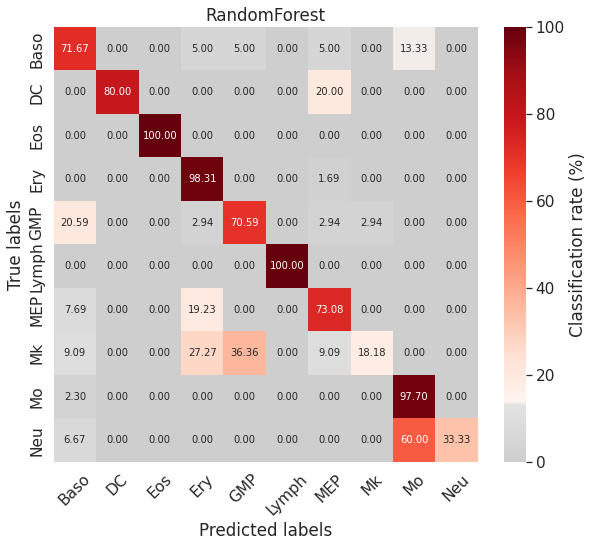

Accuracy: 0.8421052631578947: Misclassification: 0.1578947368421053
              precision    recall  f1-score   support

        Baso       0.75      0.72      0.74        60
          DC       1.00      0.80      0.89         5
         Eos       1.00      1.00      1.00         2
         Ery       0.94      0.98      0.96       177
         GMP       0.77      0.71      0.74        34
       Lymph       1.00      1.00      1.00         5
         MEP       0.68      0.73      0.70        26
          Mk       0.67      0.18      0.29        11
          Mo       0.77      0.98      0.86        87
         Neu       1.00      0.33      0.50        30

    accuracy                           0.84       437
   macro avg       0.86      0.74      0.77       437
weighted avg       0.85      0.84      0.83       437

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

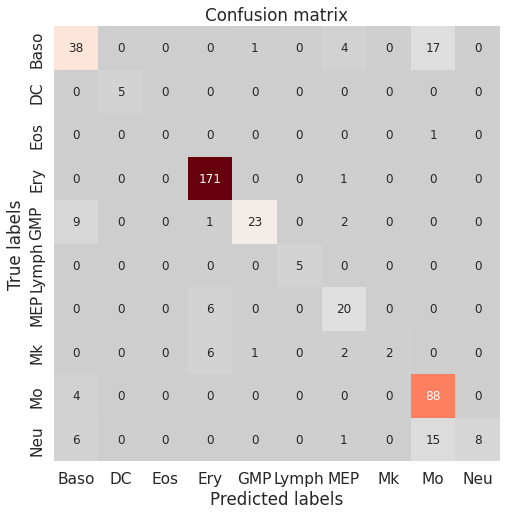

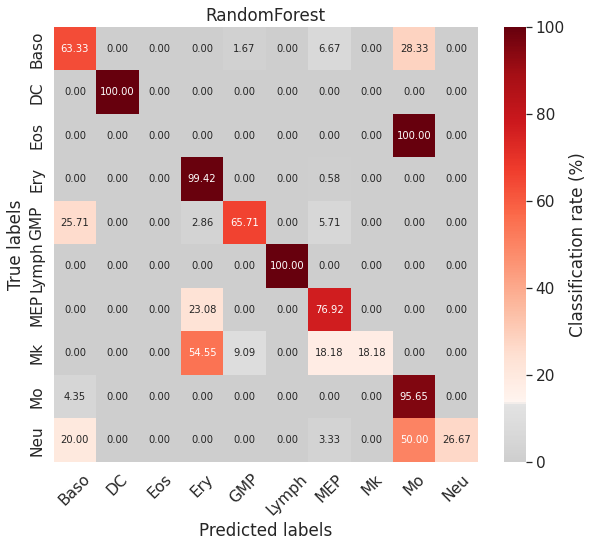

Accuracy: 0.8237986270022883: Misclassification: 0.17620137299771166
              precision    recall  f1-score   support

        Baso       0.67      0.63      0.65        60
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.93      0.99      0.96       172
         GMP       0.92      0.66      0.77        35
       Lymph       1.00      1.00      1.00         5
         MEP       0.67      0.77      0.71        26
          Mk       1.00      0.18      0.31        11
          Mo       0.73      0.96      0.83        92
         Neu       1.00      0.27      0.42        30

    accuracy                           0.82       437
   macro avg       0.79      0.65      0.66       437
weighted avg       0.84      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

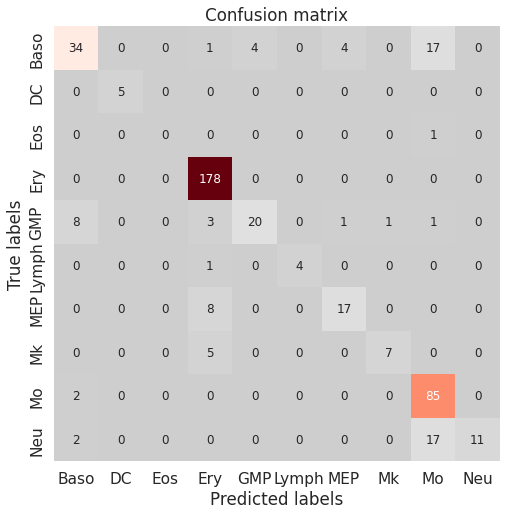

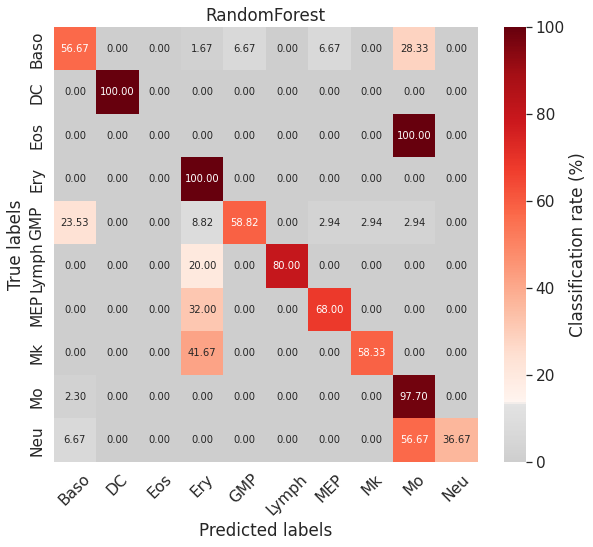

Accuracy: 0.8260869565217391: Misclassification: 0.17391304347826086
              precision    recall  f1-score   support

        Baso       0.74      0.57      0.64        60
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.91      1.00      0.95       178
         GMP       0.83      0.59      0.69        34
       Lymph       1.00      0.80      0.89         5
         MEP       0.77      0.68      0.72        25
          Mk       0.88      0.58      0.70        12
          Mo       0.70      0.98      0.82        87
         Neu       1.00      0.37      0.54        30

    accuracy                           0.83       437
   macro avg       0.78      0.66      0.69       437
weighted avg       0.84      0.83      0.81       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


CPU times: user 5min 43s, sys: 4.78 s, total: 5min 48s
Wall time: 4min 38s


In [16]:
%%time
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                99648     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

18/18 [==============================] - 0s 5ms/step - loss: 1.1461 - accuracy: 0.7916 - auc: 0.9750 - precision: 1.0000 - recall: 0.0343 - val_loss: 1.5391 - val_accuracy: 0.7185 - val_auc: 0.9490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00018: val_loss improved from 1.56865 to 1.53912, saving model to weights/best_model_annotation.h5
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 1.1105 - accuracy: 0.8031 - auc: 0.9737 - precision: 1.0000 - recall: 0.0378 - val_loss: 1.5138 - val_accuracy: 0.7208 - val_auc: 0.9472 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00019: val_loss improved from 1.53912 to 1.51383, saving model to weights/best_model_annotation.h5
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 1.0588 - accuracy: 0.8237 - auc: 0.9792 - precision: 1.0000 - recall: 0.0469 - val_loss: 1.4961 - val_accuracy: 0.7414 - val_auc: 0.9530 - val_precision: 1.0000 - val_recall: 0.0092

Epoch 00020: val

18/18 [==============================] - 0s 9ms/step - loss: 0.5143 - accuracy: 0.9542 - auc: 0.9983 - precision: 0.9991 - recall: 0.6508 - val_loss: 1.0811 - val_accuracy: 0.7368 - val_auc: 0.9597 - val_precision: 0.9006 - val_recall: 0.3318

Epoch 00041: val_loss improved from 1.08577 to 1.08107, saving model to weights/best_model_annotation.h5
Epoch 42/100
18/18 [==============================] - 0s 10ms/step - loss: 0.5148 - accuracy: 0.9634 - auc: 0.9987 - precision: 0.9983 - recall: 0.6720 - val_loss: 1.0715 - val_accuracy: 0.7437 - val_auc: 0.9579 - val_precision: 0.8706 - val_recall: 0.3387

Epoch 00042: val_loss improved from 1.08107 to 1.07154, saving model to weights/best_model_annotation.h5
Epoch 43/100
18/18 [==============================] - 0s 8ms/step - loss: 0.4947 - accuracy: 0.9639 - auc: 0.9989 - precision: 0.9992 - recall: 0.7275 - val_loss: 1.0409 - val_accuracy: 0.7346 - val_auc: 0.9600 - val_precision: 0.8995 - val_recall: 0.3890

Epoch 00043: val_loss improved 

Epoch 66/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2648 - accuracy: 0.9805 - auc: 0.9997 - precision: 0.9975 - recall: 0.9141 - val_loss: 0.8829 - val_accuracy: 0.7437 - val_auc: 0.9587 - val_precision: 0.8278 - val_recall: 0.5721

Epoch 00066: val_loss did not improve from 0.87717
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2493 - accuracy: 0.9857 - auc: 0.9999 - precision: 0.9994 - recall: 0.9267 - val_loss: 0.8697 - val_accuracy: 0.7483 - val_auc: 0.9590 - val_precision: 0.8269 - val_recall: 0.5904

Epoch 00067: val_loss improved from 0.87717 to 0.86971, saving model to weights/best_model_annotation.h5
Epoch 68/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2329 - accuracy: 0.9823 - auc: 0.9998 - precision: 0.9981 - recall: 0.9216 - val_loss: 0.8491 - val_accuracy: 0.7643 - val_auc: 0.9601 - val_precision: 0.8376 - val_recall: 0.6018

Epoch 00068: val_loss improved from 0.86971 to 0.84914, saving model to 

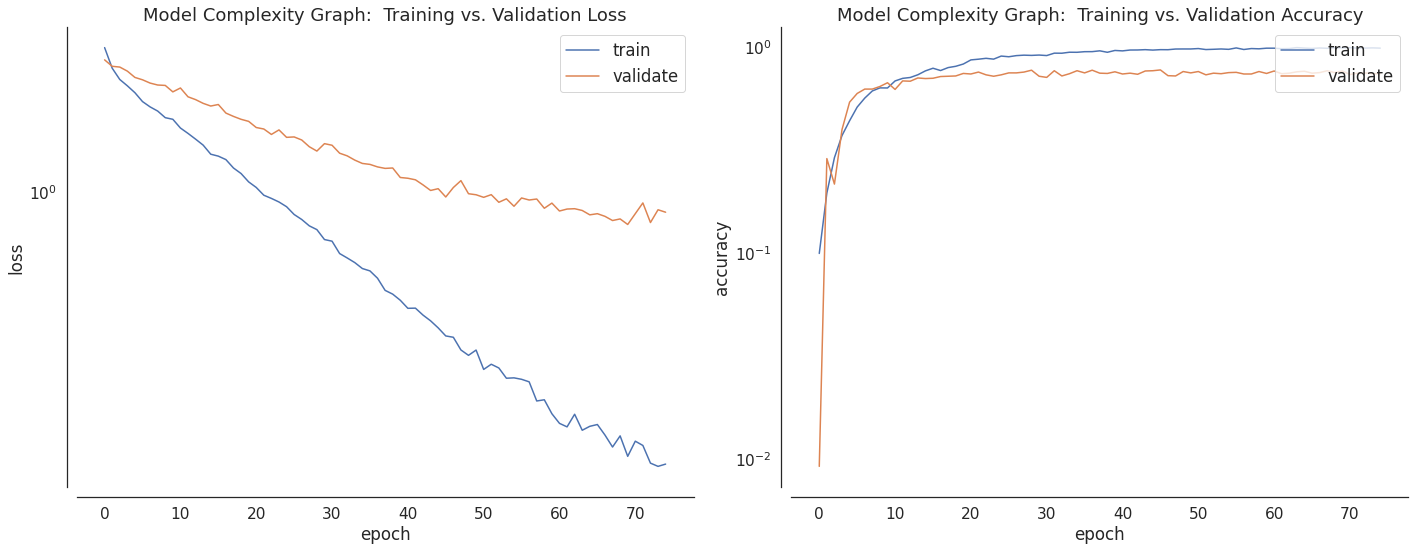

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

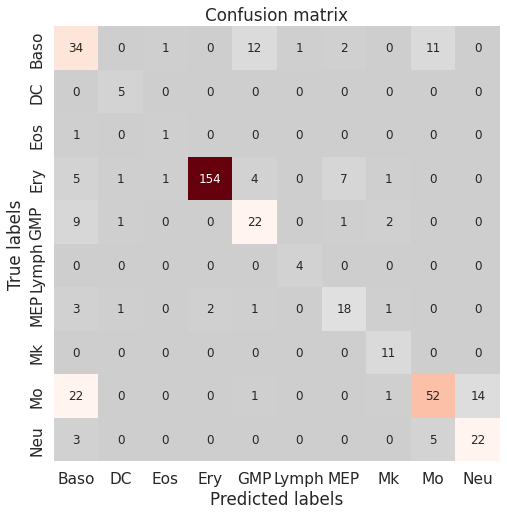

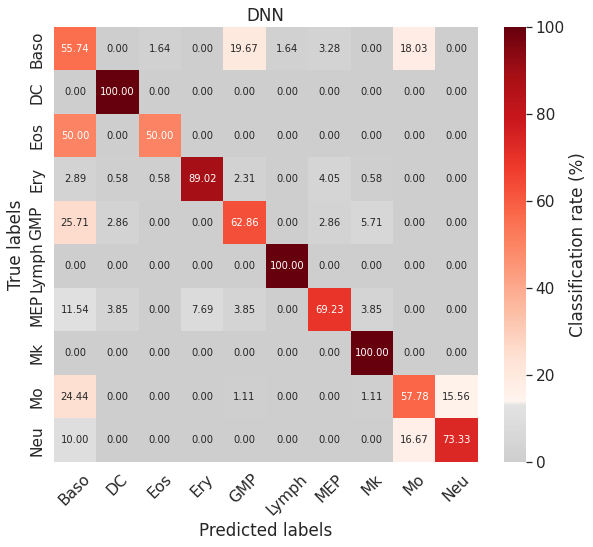

              precision    recall  f1-score   support

        Baso       0.44      0.56      0.49        61
          DC       0.62      1.00      0.77         5
         Eos       0.33      0.50      0.40         2
         Ery       0.99      0.89      0.94       173
         GMP       0.55      0.63      0.59        35
       Lymph       0.80      1.00      0.89         4
         MEP       0.64      0.69      0.67        26
          Mk       0.69      1.00      0.81        11
          Mo       0.76      0.58      0.66        90
         Neu       0.61      0.73      0.67        30

    accuracy                           0.74       437
   macro avg       0.64      0.76      0.69       437
weighted avg       0.77      0.74      0.75       437

14/14 [==============================] - 0s 2ms/step - loss: 0.8302 - accuracy: 0.7620 - auc: 0.9618 - precision: 0.8307 - recall: 0.6064


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


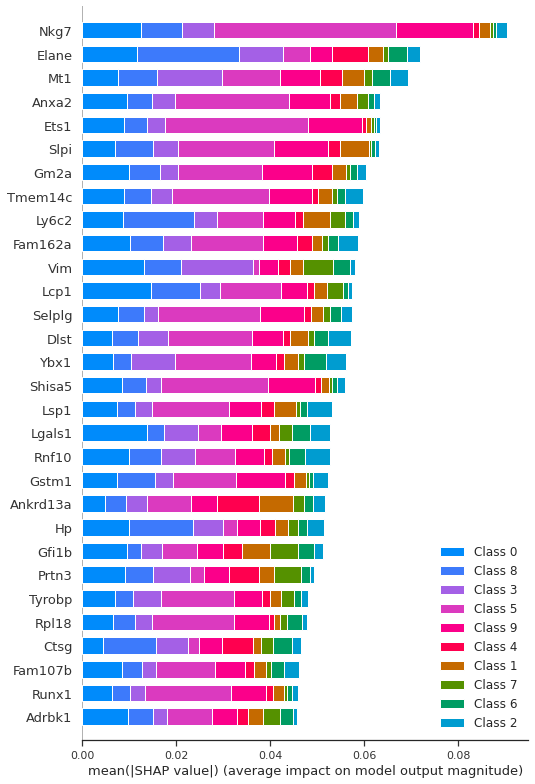

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                99648     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None


Epoch 00018: val_loss did not improve from 1.49816
Epoch 19/100
18/18 [==============================] - 0s 10ms/step - loss: 1.1022 - accuracy: 0.8157 - auc: 0.9760 - precision: 1.0000 - recall: 0.0458 - val_loss: 1.5213 - val_accuracy: 0.7574 - val_auc: 0.9591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00019: val_loss did not improve from 1.49816
Epoch 20/100
18/18 [==============================] - 0s 8ms/step - loss: 1.0523 - accuracy: 0.8334 - auc: 0.9792 - precision: 1.0000 - recall: 0.0544 - val_loss: 1.4952 - val_accuracy: 0.7918 - val_auc: 0.9613 - val_precision: 1.0000 - val_recall: 0.0069

Epoch 00020: val_loss improved from 1.49816 to 1.49522, saving model to weights/best_model_annotation.h5
Epoch 21/100
18/18 [==============================] - 0s 9ms/step - loss: 1.0445 - accuracy: 0.8357 - auc: 0.9810 - precision: 1.0000 - recall: 0.0710 - val_loss: 1.4530 - val_accuracy: 0.7757 - val_auc: 0.9584 - val_precision: 1.0000 - val_recall: 0.0137

Epoch 00021:

18/18 [==============================] - 0s 9ms/step - loss: 0.4846 - accuracy: 0.9571 - auc: 0.9989 - precision: 1.0000 - recall: 0.7264 - val_loss: 1.0221 - val_accuracy: 0.7735 - val_auc: 0.9658 - val_precision: 0.9045 - val_recall: 0.3684

Epoch 00043: val_loss did not improve from 0.97383
Epoch 44/100
18/18 [==============================] - 0s 10ms/step - loss: 0.4645 - accuracy: 0.9645 - auc: 0.9988 - precision: 0.9984 - recall: 0.7195 - val_loss: 0.9438 - val_accuracy: 0.7963 - val_auc: 0.9690 - val_precision: 0.9283 - val_recall: 0.4737

Epoch 00044: val_loss improved from 0.97383 to 0.94379, saving model to weights/best_model_annotation.h5
Epoch 45/100
18/18 [==============================] - 0s 11ms/step - loss: 0.4350 - accuracy: 0.9731 - auc: 0.9990 - precision: 0.9992 - recall: 0.7384 - val_loss: 0.9824 - val_accuracy: 0.7918 - val_auc: 0.9646 - val_precision: 0.9303 - val_recall: 0.4279

Epoch 00045: val_loss did not improve from 0.94379
Epoch 46/100
18/18 [=============

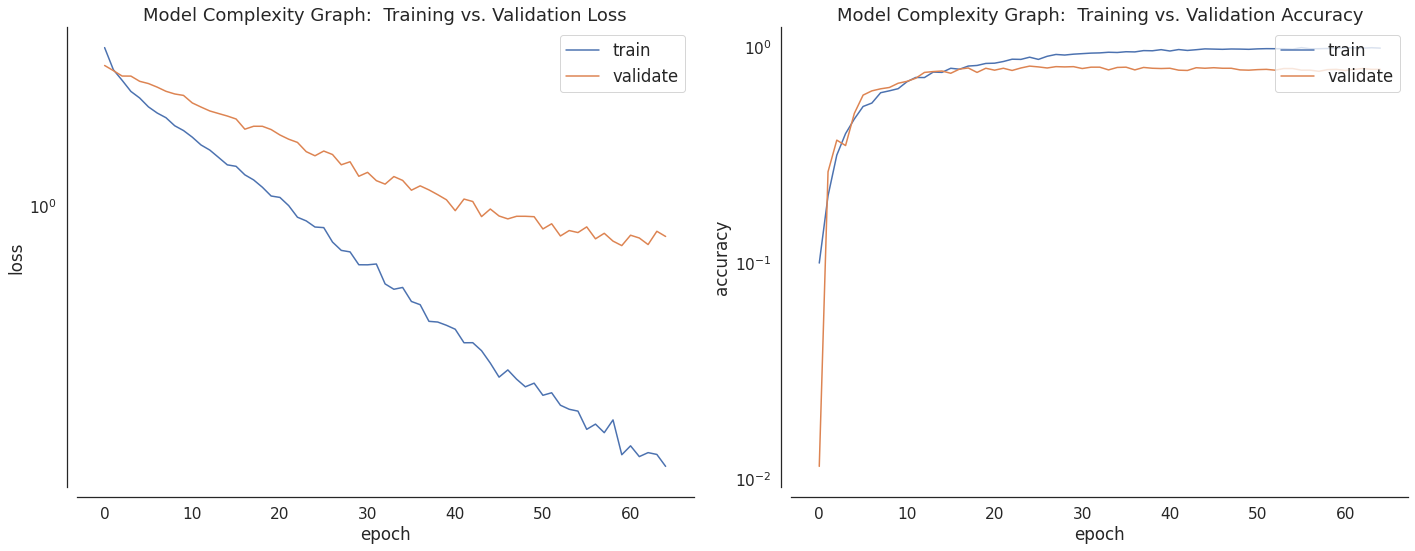

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

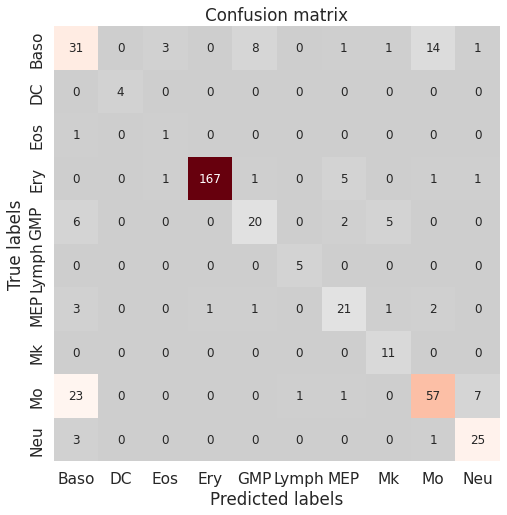

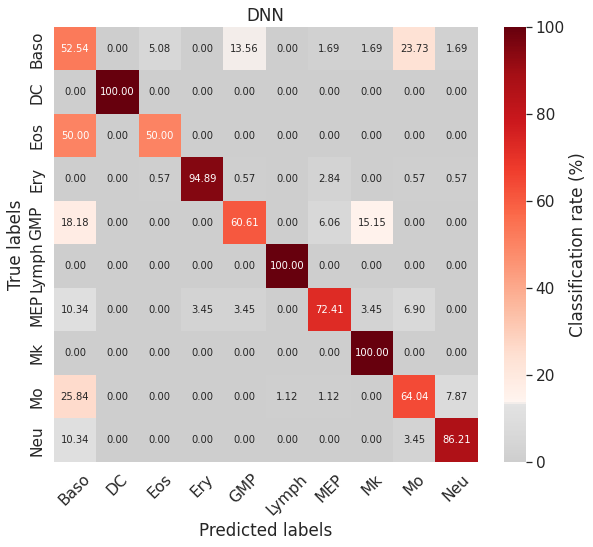

              precision    recall  f1-score   support

        Baso       0.46      0.53      0.49        59
          DC       1.00      1.00      1.00         4
         Eos       0.20      0.50      0.29         2
         Ery       0.99      0.95      0.97       176
         GMP       0.67      0.61      0.63        33
       Lymph       0.83      1.00      0.91         5
         MEP       0.70      0.72      0.71        29
          Mk       0.61      1.00      0.76        11
          Mo       0.76      0.64      0.70        89
         Neu       0.74      0.86      0.79        29

    accuracy                           0.78       437
   macro avg       0.70      0.78      0.73       437
weighted avg       0.80      0.78      0.79       437

14/14 [==============================] - 0s 2ms/step - loss: 0.8096 - accuracy: 0.7826 - auc: 0.9678 - precision: 0.8951 - recall: 0.6247


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


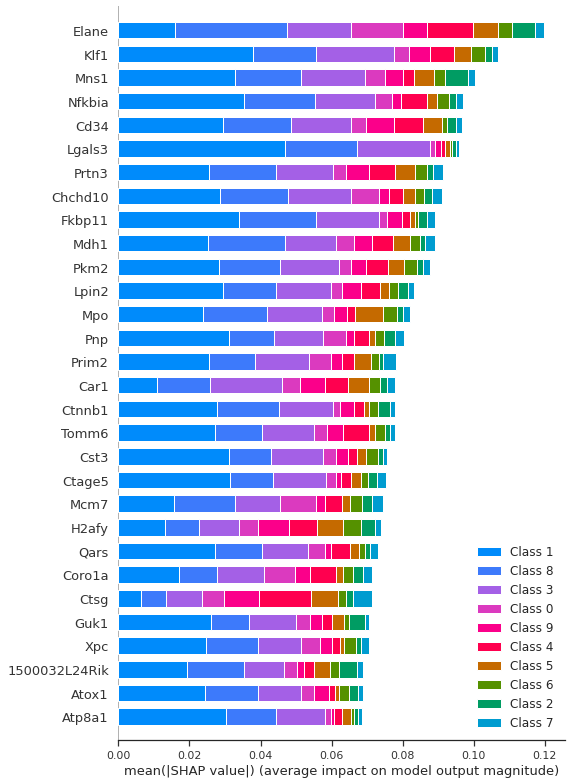

 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

18/18 [==============================] - 0s 10ms/step - loss: 1.1168 - accuracy: 0.8060 - auc: 0.9749 - precision: 1.0000 - recall: 0.0475 - val_loss: 1.4839 - val_accuracy: 0.7094 - val_auc: 0.9562 - val_precision: 1.0000 - val_recall: 0.0046

Epoch 00019: val_loss improved from 1.55147 to 1.48389, saving model to weights/best_model_annotation.h5
Epoch 20/100
18/18 [==============================] - 0s 9ms/step - loss: 1.0674 - accuracy: 0.8260 - auc: 0.9785 - precision: 1.0000 - recall: 0.0538 - val_loss: 1.4962 - val_accuracy: 0.7346 - val_auc: 0.9477 - val_precision: 1.0000 - val_recall: 0.0137

Epoch 00020: val_loss did not improve from 1.48389
Epoch 21/100
18/18 [==============================] - 0s 9ms/step - loss: 1.0320 - accuracy: 0.8500 - auc: 0.9830 - precision: 1.0000 - recall: 0.0744 - val_loss: 1.4506 - val_accuracy: 0.7414 - val_auc: 0.9527 - val_precision: 1.0000 - val_recall: 0.0160

Epoch 00021: val_loss improved from 1.48389 to 1.45062, saving model to weights/best_

18/18 [==============================] - 0s 10ms/step - loss: 0.4765 - accuracy: 0.9702 - auc: 0.9990 - precision: 1.0000 - recall: 0.7252 - val_loss: 1.0498 - val_accuracy: 0.7346 - val_auc: 0.9567 - val_precision: 0.9495 - val_recall: 0.4302

Epoch 00043: val_loss improved from 1.06396 to 1.04982, saving model to weights/best_model_annotation.h5
Epoch 44/100
18/18 [==============================] - 0s 9ms/step - loss: 0.4770 - accuracy: 0.9611 - auc: 0.9980 - precision: 0.9976 - recall: 0.7161 - val_loss: 1.0098 - val_accuracy: 0.7414 - val_auc: 0.9591 - val_precision: 0.9378 - val_recall: 0.4828

Epoch 00044: val_loss improved from 1.04982 to 1.00982, saving model to weights/best_model_annotation.h5
Epoch 45/100
18/18 [==============================] - 0s 12ms/step - loss: 0.4422 - accuracy: 0.9594 - auc: 0.9990 - precision: 0.9992 - recall: 0.7487 - val_loss: 0.9894 - val_accuracy: 0.7529 - val_auc: 0.9621 - val_precision: 0.9406 - val_recall: 0.4714

Epoch 00045: val_loss improved

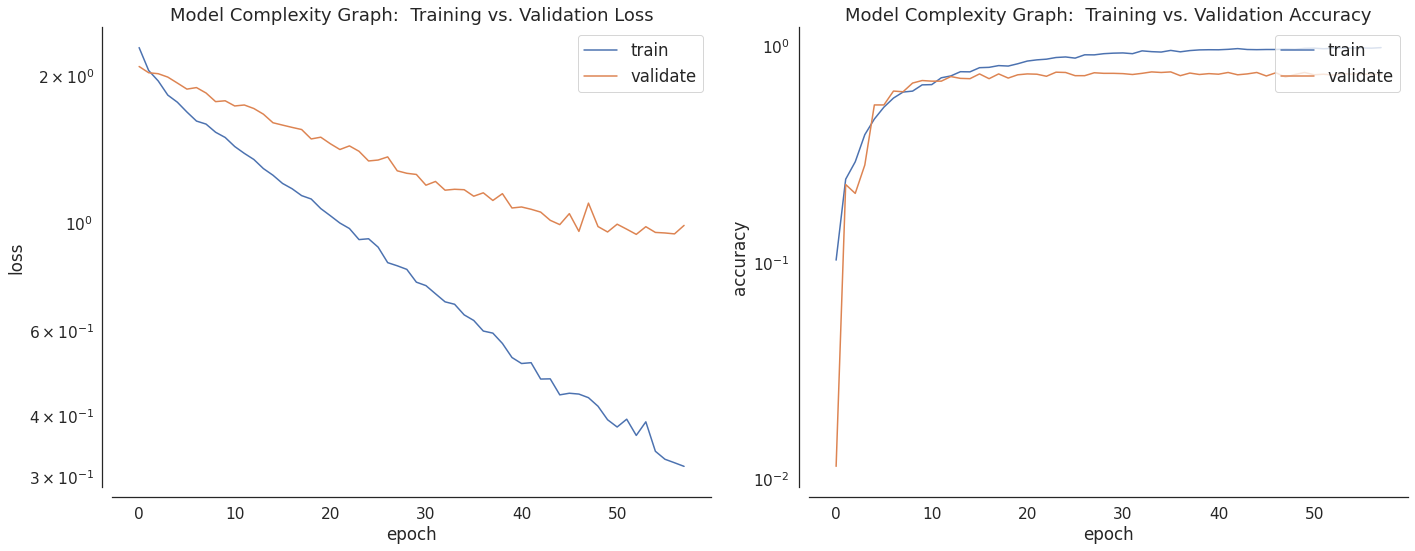

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

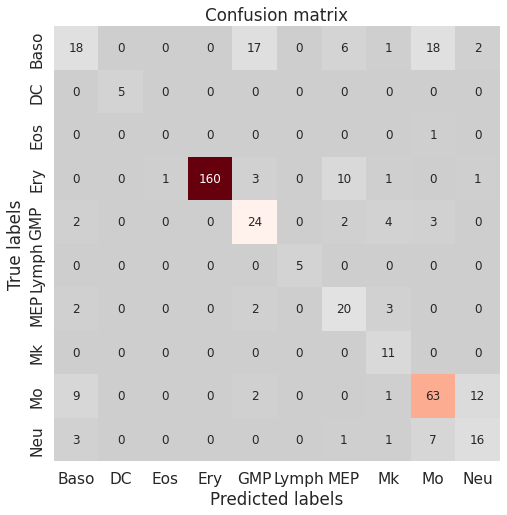

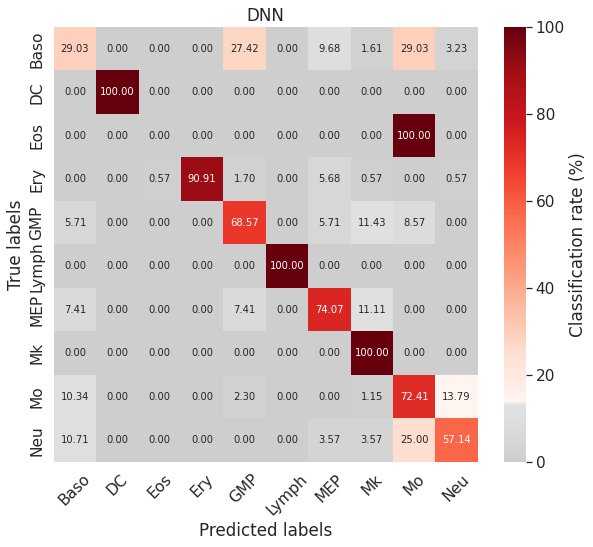

              precision    recall  f1-score   support

        Baso       0.53      0.29      0.38        62
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       1.00      0.91      0.95       176
         GMP       0.50      0.69      0.58        35
       Lymph       1.00      1.00      1.00         5
         MEP       0.51      0.74      0.61        27
          Mk       0.50      1.00      0.67        11
          Mo       0.68      0.72      0.70        87
         Neu       0.52      0.57      0.54        28

    accuracy                           0.74       437
   macro avg       0.62      0.69      0.64       437
weighted avg       0.75      0.74      0.74       437



ValueError: Cannot assign to variable dense_12/kernel:0 due to variable shape (3113, 32) and value shape (4000, 32) are incompatible

In [17]:
%%time
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(train_X_y, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(train_X_y, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

In [18]:
# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
np.random.seed(possible_seeds[seed_index])
seed_index += 1

## Train RankCorr

In [19]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 4.7# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

## Train L1 VAE

In [20]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 41.74it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 42.54it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Setting `Trainer(weights_summary=None)` is depre

## Train Global Gate

In [15]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 31.81it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 31.52i

## MarkerMap Unsupervised

In [16]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 28.68i

## MarkerMap Supervised

In [17]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 29.62it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 29.78i

## MarkerMap Mixed Supervision

In [18]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 25.57it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 26.23i

## Concrete VAE

In [19]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 42.85it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 41.31i

## LassoNet

In [20]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [21]:
k = 50
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, z_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

### Get Model Metrics from KNNs Classifiers

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [22]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. 

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

# Results and Visualizations

## Accuracies and F1

In [23]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [24]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [25]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.184432          0.796108   
L1 VAE                                     0.530952          0.405839   
Smash RF                                   0.113553          0.883150   
SMaSH DNN                                  0.169780          0.817025   
RankCorr                                   0.148718          0.844848   
Global Gate VAE                            0.381685          0.573380   
MarkerMap Unsupervised                     0.139377          0.856347   
MarkerMap Supervised                       0.107875          0.889062   
MarkerMap Mixed Supervision                0.137546          0.857452   
Concrete VAE                               0.397802          0.555225   
LassoNet                                   0.126190          0.868091   

                             Misclassification Standard Deviation  \
All Markers                                              0.013974   
L1 VAE                                                   0.032890   
Smash RF                                                 0.017298   
SMaSH DNN                                                0.026743   
RankCorr                                                 0.011254   
Global Gate VAE                                          0.029648   
MarkerMap Unsupervised                                   0.014571   
MarkerMap Supervised                                     0.012216   
MarkerMap Mixed Supervision                              0.021303   
Concrete VAE                                             0.026041   
LassoNet                                                 0.008989   

                             Weighted F1 Standard Deviation  
All Markers                                        0.016251  
L1 VAE                                             0.030681  
Smash RF                                           0.017107  
SMaSH DNN                                          0.031115  
RankCorr                                           0.012610  
Global Gate VAE                                    0.034719  
MarkerMap Unsupervised                             0.015843  
MarkerMap Supervised                               0.012318  
MarkerMap Mixed Supervision                        0.021008  
Concrete VAE                                       0.034662  
LassoNet                                           0.010088

In [26]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [27]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.320513          0.607517   
L1 VAE                                     0.632051          0.375114   
Smash RF                                   0.217216          0.767738   
SMaSH DNN                                  0.291209          0.675788   
RankCorr                                   0.256593          0.728649   
Global Gate VAE                            0.446703          0.520882   
MarkerMap Unsupervised                     0.268315          0.720669   
MarkerMap Supervised                       0.203480          0.789182   
MarkerMap Mixed Supervision                0.253114          0.735446   
Concrete VAE                               0.460989          0.512750   
LassoNet                                   0.227656          0.760705   

                             Misclassification Standard Deviation  \
All Markers                                              0.016806   
L1 VAE                                                   0.058925   
Smash RF                                                 0.015950   
SMaSH DNN                                                0.018479   
RankCorr                                                 0.030200   
Global Gate VAE                                          0.024455   
MarkerMap Unsupervised                                   0.014749   
MarkerMap Supervised                                     0.017345   
MarkerMap Mixed Supervision                              0.031699   
Concrete VAE                                             0.034314   
LassoNet                                                 0.022161   

                             Weighted F1 Standard Deviation  
All Markers                                        0.022552  
L1 VAE                                             0.051464  
Smash RF                                           0.019119  
SMaSH DNN                                          0.023532  
RankCorr                                           0.036889  
Global Gate VAE                                    0.028861  
MarkerMap Unsupervised                             0.013766  
MarkerMap Supervised                               0.018494  
MarkerMap Mixed Supervision                        0.033155  
Concrete VAE                                       0.035681  
LassoNet                                           0.024822

## Confusion Matrices

k = 50

k = 50

### All Markers Baseline

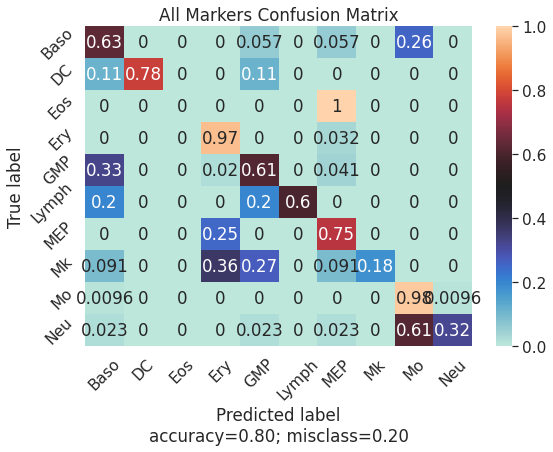

In [28]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [29]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

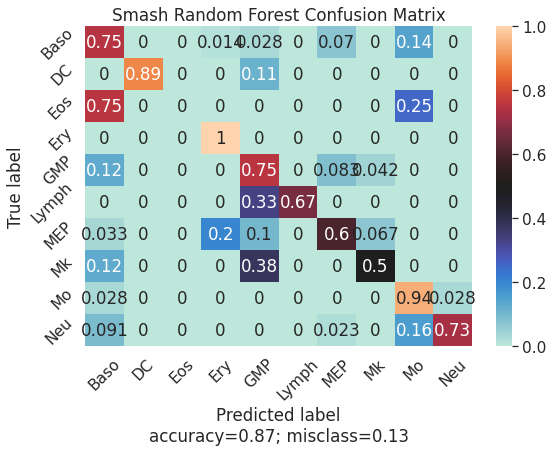

In [30]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap='icefire')

### Smash DNN

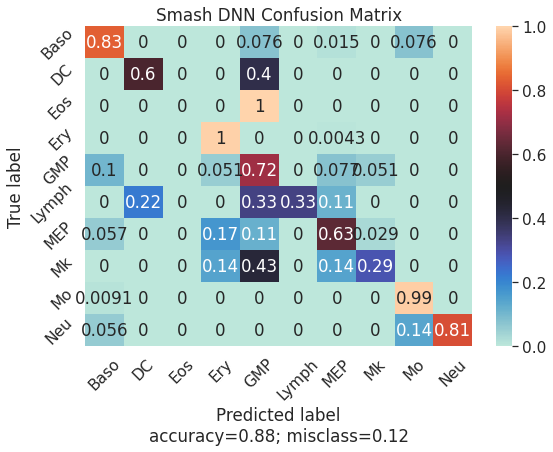

In [31]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

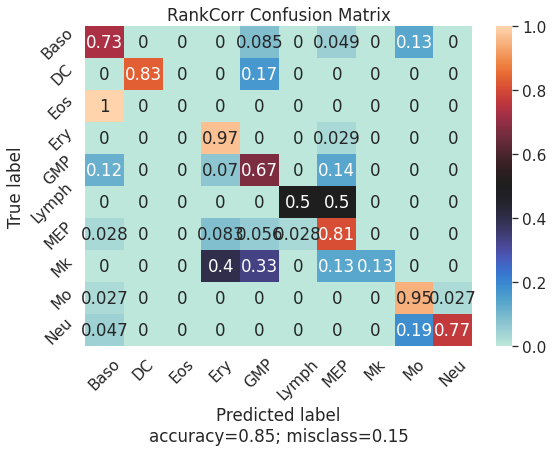

In [32]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap='icefire')

### L1 VAE

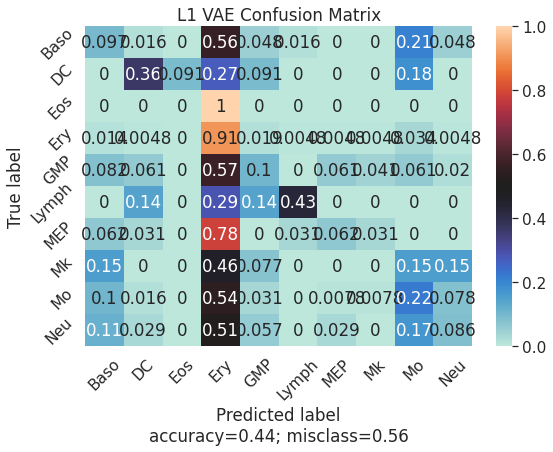

In [33]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap='icefire')

### Global Gate VAE

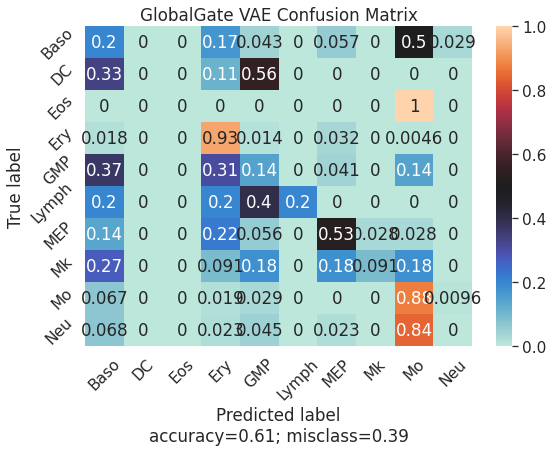

In [34]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap='icefire')

### MarkerMap Unsupervised

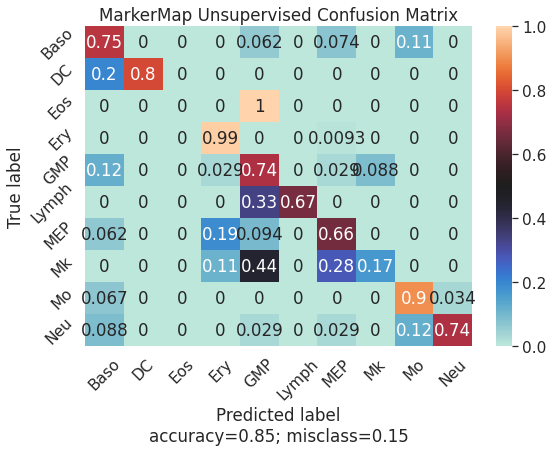

In [35]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### MarkerMap Supervised


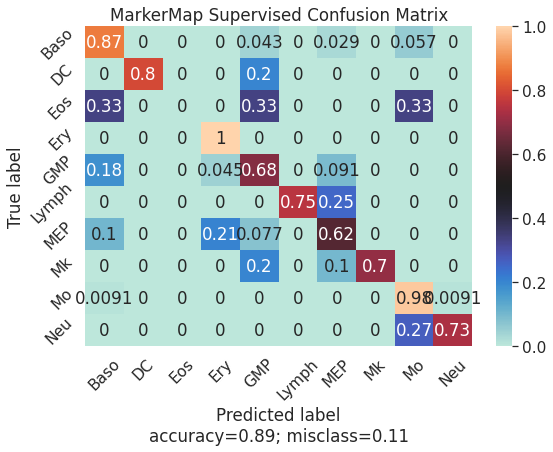

In [36]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

### MarkerMap Mixed Supervision

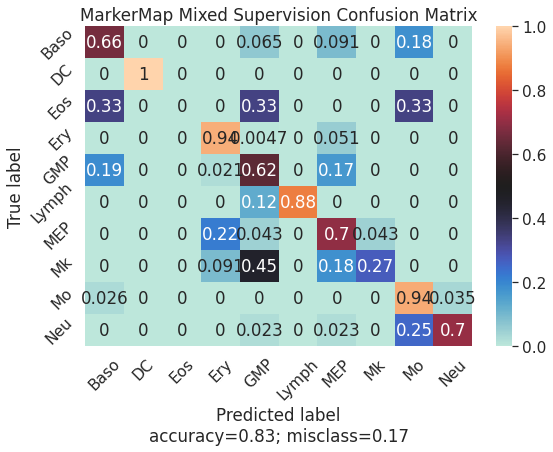

In [37]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

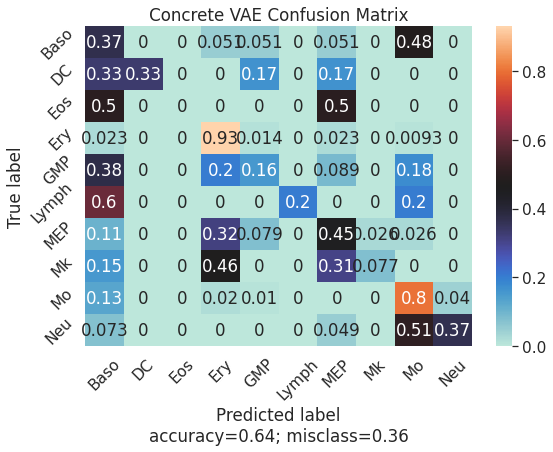

In [38]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap='icefire')

## LassoNet

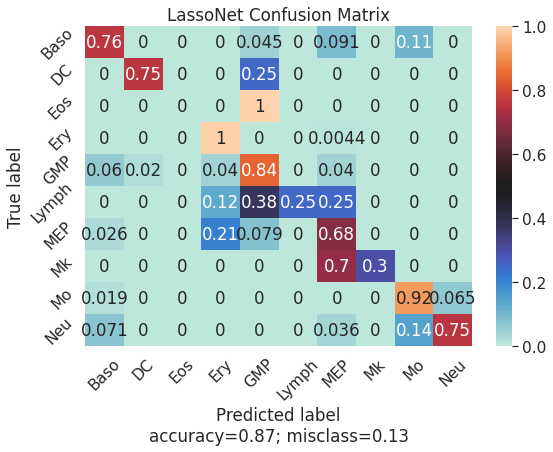

In [39]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')